In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')


In [64]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

In [ ]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
loader=DirectoryLoader("../input",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()


[Document(metadata={'source': '..\\input\\cricketrules.txt'}, page_content='Cricket Rules \n\n- A cricket match is played between two teams of 11 players each.\n\n- One team bats to score runs while the other bowls and fields to restrict runs and dismiss batters.\n\n- The team with the most runs at the end of the match wins.\n\n- The game is played in formats like Test, ODI (50 overs), T20 (20 overs), and T10 (10 overs).\n\n- Runs are scored by running between the wickets or hitting boundaries (4 for ground hits, 6 for over the boundary).\n\n- A bowler delivers 6 legal balls in one over.\n\n- Each team takes turns to bat and bowl based on the format.\n\n- A batter is out if bowled, caught, run out, LBW, stumped, or hit wicket.\n\n- No-balls and wides give extra runs and require an extra delivery.\n\n- Powerplays restrict fielding positions during initial overs in limited-overs formats.\n\n- DRS (Decision Review System) allows teams to review umpire decisions using technology.\n\n- Umpi

In [66]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [67]:
new_docs=text_splitter.split_documents(documents=docs)

In [21]:
doc_string=[doc.page_content for doc in new_docs]


In [22]:
db=Chroma.from_documents(new_docs,embeddings)


In [27]:
retriever=db.as_retriever(search_kwargs={"k": 3})
retriever.invoke("cricket rules?")

[Document(metadata={'source': '..\\input\\cricketrules.txt'}, page_content='Cricket Rules \n\n- A cricket match is played between two teams of 11 players each.\n\n- One team bats to score runs while the other bowls and fields to restrict runs and dismiss batters.'),
 Document(metadata={'source': '..\\input\\cricketrules.txt'}, page_content='- A bowler delivers 6 legal balls in one over.\n\n- Each team takes turns to bat and bowl based on the format.\n\n- A batter is out if bowled, caught, run out, LBW, stumped, or hit wicket.'),
 Document(metadata={'source': '..\\input\\cricketrules.txt'}, page_content='- Runs are scored by running between the wickets or hitting boundaries (4 for ground hits, 6 for over the boundary).\n\n- A bowler delivers 6 legal balls in one over.')]

In [68]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [69]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [70]:
from langchain.output_parsers import PydanticOutputParser
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)


In [71]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [86]:
# SUPERVISOR FUNCTION
def function_1(state:AgentState):
    
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [Cricket, Fact Check, Not Related].
        - If the query requires real-time information or recent events, classify it as "Fact Check".
        - If the query is about Cricket (rules, history, teams), classify it as "Cricket".
        - If the query does not fit these categories, classify it as "Not Related".
        
    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [87]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    # Ensure proper validation before routing
    if last_message not in ["Cricket", "Fact Check", "Not Related"]:
        print("Validation failed—Returning to Supervisor Node...")        
    # Ask Supervisor to reclassify the query
        state["messages"][-1] = "Not Related"
        return router(state) 
    
    if "cricket" in last_message.lower():
        return "RAG Call"
    elif "fact check" in last_message.lower():  
        return "TavilySearch Call"
    else:
        return "LLM Call"

In [88]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    print("Inside Rag function",question)
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [89]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [90]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os
      
def function_4(state:AgentState):
    print("-> TAVILY SEARCH ->")
    question = state["messages"][0]
    TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
    # Tavily Search    
    search_results = TavilySearchResults(api_key=TAVILY_API_KEY).invoke({"query": question})
    
    if not search_results:
        return {"messages": ["No results found."]}
    
    # Format the search results
    formatted_results = "\n\n".join(result["content"] for result in search_results)
    
    return {"messages": [formatted_results]}

In [91]:
from langgraph.graph import StateGraph,END
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("Tavily Search",function_4)
workflow.set_entry_point("Supervisor")

In [92]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "TavilySearch Call": "Tavily Search"
    }
)

In [93]:
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)
workflow.add_edge("Tavily Search",END)
app=workflow.compile()

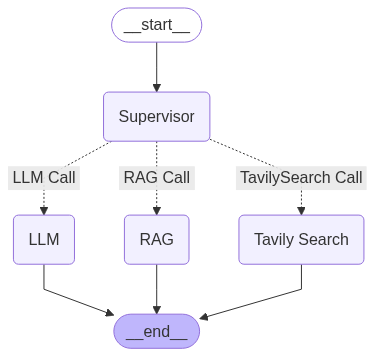

In [94]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [95]:
state={"messages":["what is the rule in cricket?"]}
app.invoke(state)
result=app.invoke(state)
result["messages"][-1]

Question what is the rule in cricket?
Parsed response: Topic='Cricket' Reasoning='The query asks about the rules in cricket, which is a topic directly related to the sport of cricket.'
-> ROUTER ->
last_message: Cricket
-> RAG Call ->
Inside Rag function what is the rule in cricket?
Question what is the rule in cricket?
Parsed response: Topic='Cricket' Reasoning="The query directly asks about the rules in cricket, which is a topic related to the sport's regulations and gameplay."
-> ROUTER ->
last_message: Cricket
-> RAG Call ->
Inside Rag function what is the rule in cricket?


'Cricket is played between two teams of 11, with one batting to score runs while the other bowls and fields to dismiss batters.  Runs are scored by hitting boundaries (4 or 6) or running between wickets.  A batter can be out in several ways, including being bowled, caught, or run out.'

In [54]:
state={"messages":["who won the IPL Tournament in 2025?"]}
app.invoke(state)
result=app.invoke(state)
result["messages"][-1]

Question who won the IPL Tournament in 2025?
Parsed response: Topic='Fact Check' Reasoning="The query asks about the winner of a future IPL tournament.  Determining the winner requires checking facts about a future event, making it a fact-check query.  The IPL is a cricket tournament, but the query's focus is on verifying a future outcome, not on cricket rules or history."
-> ROUTER ->
last_message: Fact Check
-> TAVILY SEARCH ->
Question who won the IPL Tournament in 2025?
Parsed response: Topic='Fact Check' Reasoning='The query asks for the winner of a future IPL tournament.  Determining the winner requires checking facts about a future event, which is a fact-check task.'
-> ROUTER ->
last_message: Fact Check
-> TAVILY SEARCH ->


'The [**IPL 2025**](https://www.olympics.com/en/news/indian-premier-league-ipl-2025-schedule-match-list) concluded on June 3 with Royal Challengers Bengaluru defeating Punjab Kings in the final to lift their maiden title.\n\nThis was the 18th edition of the [**Indian Premier League**](https://www.olympics.com/en/news/indian-premier-league-ipl-winners-list-champions) - the world’s most lucrative franchise-based T20 league.\n\nRCB became the eighth team to win the IPL trophy. [...] The top two teams - PBKS and RCB - battled it out in Qualifier 1, with the Royal Challengers winning it to earn a direct ticket to the final.\n\nHowever, PBKS ended up joining RCB in the finale after defeating MI, who defeated GT in the Eliminator.\n\nOverall, MI and CSK are the most successful teams in the IPL with five titles each, followed by KKR with three. RCB, SRH, RR, GT and the now-defunct Deccan Chargers are the other teams who have won the title.\n\n[Videos](https://www.espncricinfo.com/cricket-video

In [77]:
state={"messages":["write a song"]}
app.invoke(state)
result=app.invoke(state)
result["messages"]

Question write a song
Parsed response: Topic='Not Related' Reasoning="The query 'write a song' is a creative writing prompt and does not relate to cricket or fact-checking."
-> ROUTER ->
last_message: Not Related
-> LLM Call ->
Question write a song
Parsed response: Topic='Not Related' Reasoning="The query 'write a song' is a creative writing prompt and does not relate to cricket or fact-checking."
-> ROUTER ->
last_message: Not Related
-> LLM Call ->


['write a song',
 'Not Related',
 "(Verse 1)\nSunrise paints the city gold, another day begins to unfold\nThe rhythm of the streets takes hold, a story waiting to be told\nA million hurried footsteps fall, a symphony of rise and fall\nEach face a story, standing tall, answering life's insistent call\n\n(Chorus)\nThis is the song of everyday, the hustle and the heart's ballet\nOf laughter shared and tears that stray, in the fleeting light of day\nA tapestry of joy and pain, a sunlit shower, then the rain\nRepeating patterns, again, again, the rhythm of life's refrain\n\n(Verse 2)\nA lover's whisper, soft and low, a promise whispered, soft aglow\nA parent's hand, a gentle flow, guiding a child where they should go\nA worker's sweat, a weary sigh, beneath a vast and endless sky\nA silent prayer, a hopeful cry, as moments pass us swiftly by\n\n(Chorus)\nThis is the song of everyday, the hustle and the heart's ballet\nOf laughter shared and tears that stray, in the fleeting light of day\nA 